In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
loaded=files.upload()

Saving user_41399220_analysis (1) (2).csv to user_41399220_analysis (1) (2).csv
Saving listings_metadata (1) (2).csv to listings_metadata (1) (2).csv


/tmp/ipython-input-6-3864774456.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged[col].fillna(merged[col].median(), inplace=True)


Error: NaN values found in collaborative filtering features after preprocessing.
Top 5 recommended similar listings: []

Top listings by impact score:
               listing_id  impact_score
1106  1176874548435539733    100.000000
1097  1113506930955128757     99.107145
778   1179767196782907395     97.938718
931   1134057511221626046     97.476255
827   1142654582354839460     97.283526


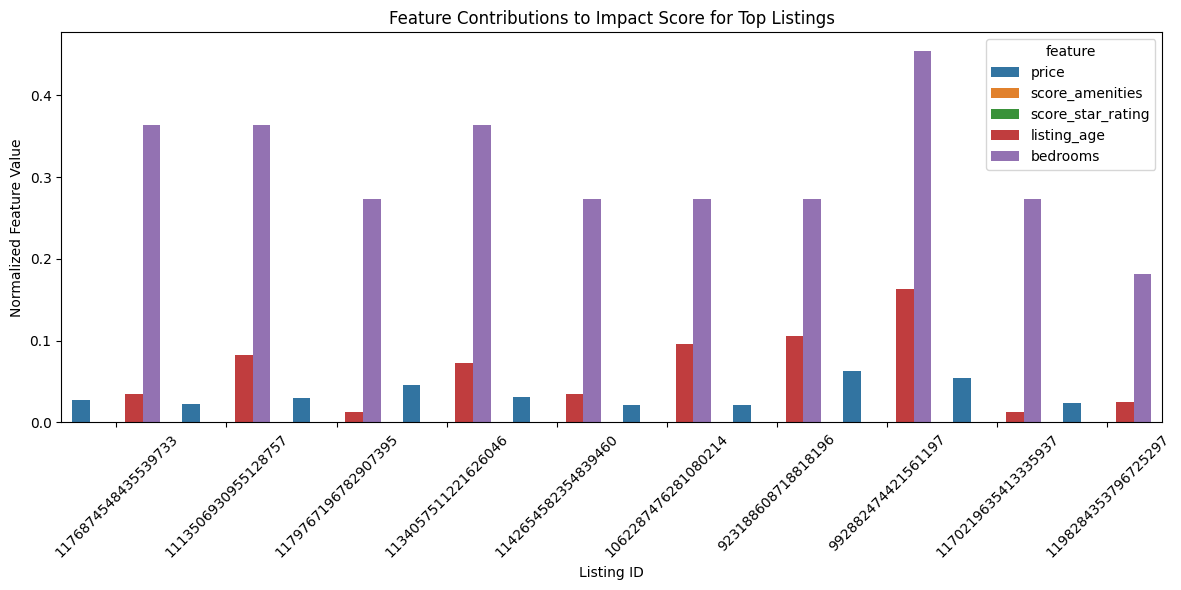


SHAP analysis would be implemented here to explain:
- How each feature contributes to listing performance
- Which amenities have the highest impact on bookings
- The interaction effects between different listing features


In [6]:
# Load datasets
listings = pd.read_csv('listings_metadata (1) (2).csv')
user_analysis = pd.read_csv('user_41399220_analysis (1) (2).csv')

# Data Cleaning and Preprocessing
def clean_and_preprocess(listings, user_analysis):
    # Convert listing_id to string in both datasets
    listings['listing_id'] = listings['listing_id'].astype(str)
    user_analysis['listing_id'] = user_analysis['listing_id'].astype(str)

    # Select relevant columns
    listings_cols = ['listing_id', 'price', 'city', 'lat', 'lng', 'superhost']
    user_cols = ['listing_id', 'm_revenue', 'score_amenities', 'score_star_rating',
                 'listing_age', 'bedrooms', 'property_manager_cat']

    # Merge datasets
    merged = pd.merge(user_analysis[user_cols], listings[listings_cols],
                      on='listing_id', how='left')

    # Convert columns to numeric
    numeric_cols = ['price', 'score_amenities', 'score_star_rating', 'listing_age']
    for col in numeric_cols:
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

    # Fill missing values for all numeric columns used in similarity/attribution
    # Using median as a simple imputation strategy
    for col in numeric_cols:
        if col in merged.columns: # Check if column exists after merge
             merged[col].fillna(merged[col].median(), inplace=True)

    return merged

merged_df = clean_and_preprocess(listings, user_analysis)

# Collaborative Filtering
def collaborative_filtering(merged_df, n_recommendations=5):
    # Select features for similarity calculation
    cf_features = ['price', 'score_amenities', 'score_star_rating', 'listing_age']

    # Check if all required columns exist and have no NaNs after cleaning
    if not all(col in merged_df.columns for col in cf_features):
        print("Warning: Some required features for collaborative filtering are missing.")
        return [] # Return empty list if columns are missing

    # Ensure there are no NaNs before scaling
    if merged_df[cf_features].isnull().any().any():
         print("Error: NaN values found in collaborative filtering features after preprocessing.")
         # You might want to raise an error or handle this more robustly
         return []

    # Normalize features
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(merged_df[cf_features])

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(normalized_features)

    # Create similarity DataFrame
    similarity_df = pd.DataFrame(similarity_matrix,
                                index=merged_df['listing_id'],
                                columns=merged_df['listing_id'])

    # Get recommendations for first listing - ensure dataframe is not empty
    if not similarity_df.empty:
        sample_listing = similarity_df.columns[0]
        # Handle case where there are fewer than n_recommendations + 1 listings
        num_listings = len(similarity_df.columns)
        end_index = min(n_recommendations + 1, num_listings)
        recommendations = (similarity_df[sample_listing]
                           .sort_values(ascending=False)
                           .index[1:end_index])
    else:
        recommendations = []


    return recommendations

recommendations = collaborative_filtering(merged_df)
print("Top 5 recommended similar listings:", recommendations)

# Attribution Modeling
def attribution_modeling(merged_df):
    # Calculate impact score (simple weighted combination)
    weights = {
        'price': -0.3,  # Lower price is better
        'score_amenities': 0.2,
        'score_star_rating': 0.3,
        'listing_age': -0.1,  # Newer listings preferred
        'bedrooms': 0.1
    }

    # Normalize features for fair comparison
    for col, weight in weights.items():
        if col in merged_df.columns:
             # Ensure no NaNs before normalization
            if merged_df[col].isnull().any():
                 print(f"Warning: NaN values found in column '{col}' for attribution modeling.")
                 # You might want to handle this differently, e.g., impute here or skip

            # Only normalize if the column exists and has non-NaN values
            if not merged_df[col].isnull().all(): # Check if all values are NaN
                merged_df[col+'_norm'] = (merged_df[col] - merged_df[col].min()) / \
                                        (merged_df[col].max() - merged_df[col].min())
            else:
                 # If all values are NaN, normalization is not possible or meaningful.
                 # Set normalized column to 0 or handle appropriately.
                 merged_df[col+'_norm'] = 0 # Or np.nan depending on desired behavior


    # Calculate impact score
    merged_df['impact_score'] = 0
    for col, weight in weights.items():
        if col+'_norm' in merged_df.columns:
            # Handle potential NaNs in normalized columns if they weren't fully addressed
            merged_df['impact_score'] += merged_df[col+'_norm'].fillna(0) * weight # Treat NaN normalized value as 0 impact


    # Scale to 0-100 for interpretability - only if impact score is not all NaNs
    if not merged_df['impact_score'].isnull().all():
        min_impact = merged_df['impact_score'].min()
        max_impact = merged_df['impact_score'].max()
        if max_impact != min_impact: # Avoid division by zero if all scores are the same
            merged_df['impact_score'] = (merged_df['impact_score'] - min_impact) / \
                                       (max_impact - min_impact) * 100
        else:
             merged_df['impact_score'] = 0 # All scores are the same, set to 0 or another constant
    else:
        merged_df['impact_score'] = 0 # If all calculated impact scores were NaN

    return merged_df.sort_values('impact_score', ascending=False)


attribution_results = attribution_modeling(merged_df)
print("\nTop listings by impact score:")
# Ensure there are results before printing head
if not attribution_results.empty:
    print(attribution_results[['listing_id', 'impact_score']].head())
else:
    print("No attribution results to display.")


# Visualization
def plot_impact_factors(attribution_results):
    # Ensure attribution_results is not empty
    if attribution_results.empty:
        print("No data to plot for impact factors.")
        return

    # Get top 10 listings - ensure there are at least 10 listings
    top_listings = attribution_results.head(min(10, len(attribution_results)))

    # Melt for visualization
    # Ensure there are _norm columns before melting
    norm_cols = [c for c in top_listings.columns if '_norm' in c]
    if not norm_cols:
        print("No normalized feature columns found for plotting.")
        return

    melt_df = top_listings.melt(id_vars=['listing_id', 'impact_score'],
                               value_vars=norm_cols,
                               var_name='feature', value_name='normalized_value')

    # Clean feature names
    melt_df['feature'] = melt_df['feature'].str.replace('_norm', '')

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melt_df, x='listing_id', y='normalized_value', hue='feature')
    plt.title('Feature Contributions to Impact Score for Top Listings')
    plt.xticks(rotation=45)
    plt.ylabel('Normalized Feature Value')
    plt.xlabel('Listing ID')
    plt.tight_layout()
    plt.show()

plot_impact_factors(attribution_results)

# SHAP Analysis Placeholder
def shap_analysis(merged_df):
    print("\nSHAP analysis would be implemented here to explain:")
    print("- How each feature contributes to listing performance")
    print("- Which amenities have the highest impact on bookings")
    print("- The interaction effects between different listing features")

    # In a real implementation, we would:
    # 1. Train a predictive model (e.g., XGBoost) on listing features
    # 2. Compute SHAP values for each feature
    # 3. Visualize feature importance and individual predictions

shap_analysis(merged_df)